In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import logging
import os
import pickle
from typing import List, Tuple, Type

import numpy as np
import geopandas as gpd
import rasterio
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loading.rasterio_utils import get_thumbnail
from rasterio.plot import reshape_as_raster, reshape_as_image
import xarray as xr

from src.constants import SRC_PATH, GWS_DATA_DIR, WGS84, UTM35N, SENTINEL_DIR
SENTINEL_POLESIA_DIR = SENTINEL_DIR / "Polesia_10m"
SENTINEL_CHERNOBYL_DIR = SENTINEL_DIR / "Chernobyl_10m"

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## 1. Resampling to get image pyramid and thumbnail

In [3]:
import rasterio
from rasterio.enums import Resampling

def downsample_image(image, bands, downsample_factor = 2, resampling=Resampling.bilinear):
    
    downsampled_image = image.read(bands, 
                                   out_shape=(int(image.height / downsample_factor), 
                                              int(image.width / downsample_factor)
                                             ), 
                                   resampling=resampling)
    
    transform = image.transform * image.transform.scale(
            (image.width / downsampled_image.shape[-1]),
            (image.height / downsampled_image.shape[-2])
    )
    
    return downsampled_image, transform

def write_image(image_data, save_path, **raster_meta):
    
    with rasterio.open(save_path, 'w', **raster_meta) as target:
        target.write(image_data)
    save_path.chmod(0o664)
    
def generate_downsample(file_path, downsample_factor=2, resampling = Resampling.bilinear, overwrite=False):
    
    save_path = file_path.parent / (file_path.name.split(".")[0] + f"_downsample_{downsample_factor}x.tif")
    if not overwrite and save_path.exists():
        return
    
    with rasterio.open(file_path) as image:
        downsampled_image, transform = downsample_image(image, 
                                             image.indexes, 
                                             downsample_factor=downsample_factor,
                                             resampling = resampling)
        nbands, height, width = downsampled_image.shape

    write_image(downsampled_image, 
                save_path, 
                driver="GTiff",
                height=height,
                width=width, 
                count=nbands,
                dtype = "float64",
                crs = image.crs,
                transform = transform,
                nodata = image.nodata)
    
    
        
def generate_thumbnail(file_path, rgb_bands = [3,2,1], rescaling=3000, downsample_factor = 16, resampling = Resampling.bilinear, overwrite=False):
    
    #print(f"Generating thumbnail for {file_path}\n")
    save_path = file_path.parent / (file_path.name.split(".")[0] + "_thumbnail.tif")
    if not overwrite and save_path.exists():
        #print("Thumbnail exists already.")
        return
    
    with rasterio.open(file_path) as image:
        downsampled_image, transform = downsample_image(image, 
                                             rgb_bands, 
                                             downsample_factor=downsample_factor,
                                             resampling = resampling)
        nbands, height, width = downsampled_image.shape
        crs = image.crs
        nodata = image.nodata
        
        downsampled_image = np.clip(downsampled_image / rescaling, a_min=0, a_max=1)
    
    #print(f"Saving thumbnail as {save_path}\n")
    write_image(downsampled_image, 
                save_path, 
                driver="GTiff",
                height=height,
                width=width, 
                count=nbands,
                dtype = "float64",
                crs = crs,
                transform = transform,
                nodata = nodata)
               

In [4]:
import multiprocessing as mp
    
def generate_thumbnail_parallel(files, n_workers):
    with mp.Pool(n_workers) as pool:
        with tqdm.tqdm(total=len(files)) as progress_bar:
            for i, _ in enumerate(pool.imap_unordered(generate_thumbnail, files)):
                progress_bar.update()

def downsampler(argument_dict):
    file = argument_dict["file"]
    downsample_factor = argument_dict["downsample_factor"]
    return generate_downsample(file, downsample_factor)
                
def generate_downsamples_parallel(files, downsample_factor, n_workers):
    
    with mp.Pool(n_workers) as pool:
        with tqdm.tqdm(total=len(files)) as progress_bar:
            for i, _ in enumerate(pool.imap_unordered(downsampler, [{"file": file, "downsample_factor": downsample_factor} for file in files])):
                progress_bar.update()

### 1.1 Create thumbnails and downsamples

In [6]:
chernobyl_files = list(SENTINEL_CHERNOBYL_DIR.glob("*[0-9].tif"))
polesia_files = list(SENTINEL_POLESIA_DIR.glob("*[0-9].tif"))

In [7]:
%%time
generate_thumbnail_parallel(chernobyl_files, n_workers=22)
generate_thumbnail_parallel(polesia_files, n_workers=22)

100%|██████████| 60/60 [01:30<00:00,  1.51s/it]


CPU times: user 156 ms, sys: 252 ms, total: 408 ms
Wall time: 1min 31s


In [10]:
%%time
generate_downsamples_parallel(chernobyl_files, downsample_factor=2, n_workers=22)
generate_downsamples_parallel(polesia_files, downsample_factor=2, n_workers=22)

100%|██████████| 60/60 [01:10<00:00,  1.18s/it]

CPU times: user 146 ms, sys: 251 ms, total: 397 ms
Wall time: 1min 11s


In [8]:
%%time
generate_downsamples_parallel(chernobyl_files, downsample_factor=4, n_workers=22)
generate_downsamples_parallel(polesia_files, downsample_factor=4, n_workers=22)

100%|██████████| 60/60 [01:12<00:00,  1.21s/it]

CPU times: user 124 ms, sys: 248 ms, total: 372 ms
Wall time: 1min 12s


In [9]:
%%time
generate_downsamples_parallel(chernobyl_files, downsample_factor=8, n_workers=22)
generate_downsamples_parallel(polesia_files, downsample_factor=8, n_workers=22)

100%|██████████| 60/60 [01:16<00:00,  1.27s/it]

CPU times: user 153 ms, sys: 246 ms, total: 399 ms
Wall time: 1min 16s


## 2. Getting a sample tile

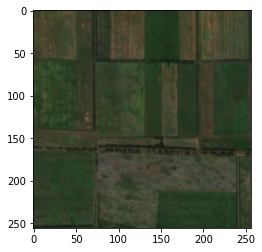

In [215]:
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image
from src.unet.satellite_image import SatelliteImage


example_folder = SENTINEL_DIR / "Example"
image_paths = list(example_folder.glob("*[0-9].tif"))

img = SatelliteImage(image_paths)

# sample tile
rgb_bands = [2,1,0]
sample_tile = reshape_as_image(img[rgb_bands, 0:256, 0:256] / 3000)
sample_tile.compute()

plt.imshow(sample_tile)

## 3. Combining satellite images from different shards

In [421]:
from src.unet.satellite_image import SatelliteImage

example_folder = SENTINEL_DIR / "Example"

thumbnail_paths = list(example_folder.glob("*_thumbnail.tif"))
image_paths = list(example_folder.glob("*[0-9].tif"))

thumbnail_img = SatelliteImage(thumbnail_paths)
img = SatelliteImage(image_paths)
img.combined_image

,Array,Chunk
Bytes,9.55 GB,524.29 kB
Shape,"(10, 10047, 11879)","(1, 256, 256)"
Count,56404 Tasks,18800 Chunks
Type,float64,numpy.ndarray


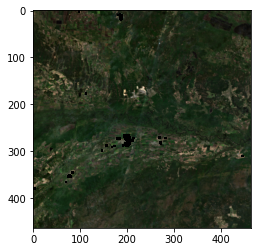

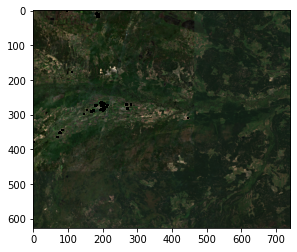

In [419]:
## Individual thumbnail
plt.imshow(reshape_as_image(thumbnail_img.shard_handles[0].data.compute()))
plt.show()

## Combined thumbnails
plt.imshow(reshape_as_image(thumbnail_img.combined_image.compute()))

## 4. Create labels from polesia vector data

In [407]:
import geopandas as gpd
polesia_path = GWS_DATA_DIR / "chernobyl_habitat_data" / "Biotope_EUNIS_ver1_1.shp"
polesia_vector = gpd.read_file(polesia_path)

superclasses = [
    8,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    2,
    3,
    4,
    5,
    5,
    6,
    6,
    6,
    7,
    7,
    7,
    7,
    9,
    10,
    11,
    11,
    12,
    12,
    13,
    13,
    13,
    13,
    14,
    14,
    15,
    15,
    19,
    16,
    17,
    18,
    18,
    18,
    18,
    18
    ]

eunis_classes = [
    1,
    21,
    22,
    23,
    24,
    29,
    30,
    31,
    33,
    2,
    3,
    4,
    38,
    43,
    35,
    36,
    37,
    25,
    26,
    27,
    28,
    5,
    6,
    7,
    8,
    9,
    11,
    16,
    17,
    18,
    32,
    19,
    34,
    39,
    40,
    10,
    41,
    42,
    12,
    13,
    14,
    15,
    20]

EUNIS_TO_SUPERCLASS = {eunis : sclass for eunis, sclass in zip(eunis_classes, superclasses)}

map_eunis_to_superclass = lambda eunis: EUNIS_TO_SUPERCLASS[eunis]

### 4.1 Inspect labels

<AxesSubplot:>

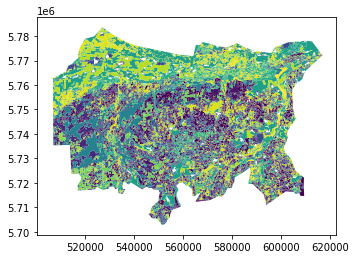

In [304]:
# Plot and check super classes
polesia_vector["superclass"] = polesia_vector.Leg.apply(map_eunis_to_superclass)
polesia_vector.plot("superclass")

In [231]:
len(polesia_vector.superclass.unique())

19

In [232]:
polesia_vector.superclass.unique()

array([ 8,  2,  3,  4,  9, 10, 11, 12, 19, 18, 13, 14,  1,  7,  6,  5, 15,
       16, 17])

### 4.2 Burn vector labels to raster

In [351]:
from src.unet.labels import empty_tif_like, burn_vector_to_raster

In [352]:
## Create empty tif template of same size as satellite dta to burn polesia data in
zeros_tif_like(img, GWS_DATA_DIR / "polesia_empty_10m_template.tif")

In [353]:
template = GWS_DATA_DIR / "polesia_empty_10m_template.tif"
burned_classes =  GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"

burn_vector_to_raster(polesia_vector,
                      colname="superclass", 
                      template_path=template, 
                      save_path=burned_classes, 
                      fill=0,
                      all_touched=True,
                      dtype="uint8")

In [354]:
burned_vals = xr.open_rasterio(burned_classes, chunks={"band": 1, "x": 256, "y": 256})

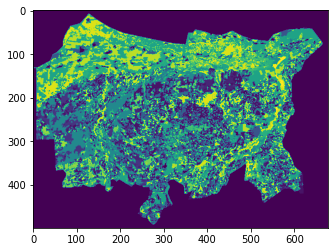

In [355]:
# Check burned raster data visually
polesia_raster_thumbnail = get_thumbnail(rasterio.open(burned_classes), height=500)
plt.imshow(polesia_raster_thumbnail);

# 5. Create pytorch dataloader

#### Load labels

In [400]:
labels_path = GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"
labels = SatelliteImage(labels_path)

#### Load satellite images

In [406]:
train_images = list(SENTINEL_POLESIA_DIR.glob("*[0-9].tif"))
unique_images = np.unique(list(map(lambda path: path.stem.split("-")[0], train_images)))
shard_paths = {img_name: list(SENTINEL_POLESIA_DIR.glob(img_name + "*[0-9].tif")) 
               for img_name in unique_images}

In [82]:
import torch

class SatelliteDataset(torch.utils.data.Dataset):
    
    def __init__(self,
                 image_paths: List[os.PathLike],
                 logger: logging.Logger,
                 seed: int = 10,
                 **kwargs
                ):
        
        if len(kwargs) > 0:
            logger.warning(f"Unused arguments: {kwargs}")
            
        raise NotImplementedError